In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.svm import LinearSVC

In [367]:
train_df = pd.read_csv("/Users/saineymanga/Desktop/train-balanced-sarcasm.csv")
test_df = pd.read_csv("/Users/saineymanga/Desktop/test-balanced.csv")

In [368]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [369]:
train_df.shape

(1010826, 10)

In [370]:
train_df.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [371]:
## Here, we do not need the cooment column, but of course it does not affect anything
train_df = train_df[['label', 'comment', 'subreddit', 'parent_comment']]

In [372]:
train_df.head(10)

,label,comment,subreddit,parent_comment
0,0,NC and NH.,politics,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",AskReddit,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,AskReddit,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,FFBraveExvius,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",pcmasterrace,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,Lollapalooza,Probably count Kanye out Since the rest of his...


In [373]:
#find comments that contain url
urls=train_df['parent_comment'].str.contains('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', regex=True) 
new = np.invert(urls)
train_df = train_df[new]

In [374]:
train_df.shape

(1010707, 4)

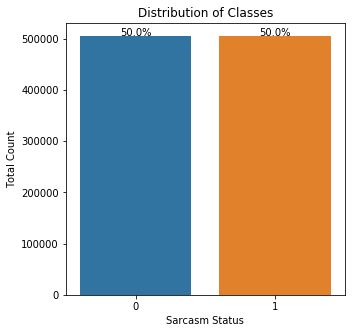

In [375]:
## Visualizing the balanceness of the labels
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= train_df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(train_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

In [376]:
## Group by to analyze subreddits
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(5)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3356,0.680870,2285
ShitRedditSays,1283,0.661730,849
worldnews,26377,0.642529,16948
Libertarian,2562,0.640125,1640


In [377]:
# Getting the top 5 popular subreddits
train_df['subreddit'].value_counts()[:5]

AskReddit          65669
politics           39494
worldnews          26377
leagueoflegends    21037
pcmasterrace       18987
Name: subreddit, dtype: int64

In [378]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace']

In [379]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [380]:
# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits 
for i in range(len(top_reddits)):
    temp = train_df.loc[train_df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

/Users/saineymanga/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [381]:
subreddit

,subreddit,sarcastic,natural,total
0,AskReddit,26363.0,39306.0,65669.0
1,politics,23910.0,15584.0,39494.0
2,worldnews,16948.0,9429.0,26377.0
3,leagueoflegends,11409.0,9628.0,21037.0
4,pcmasterrace,10760.0,8227.0,18987.0


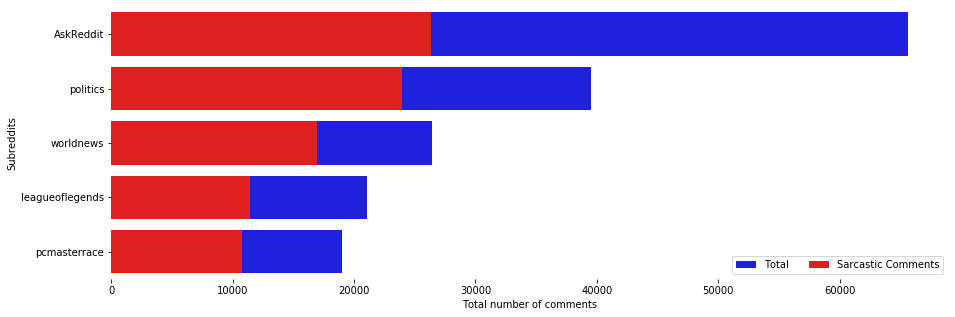

In [382]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

# MODEL FITTING

In [383]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

In [384]:
tokenizer = Tokenizer()
train_df['parent_comment']== tokenizer.fit_on_texts(train_df['parent_comment'])

0          False
1          False
2          False
3          False
4          False
           ...  
1010821    False
1010822    False
1010823    False
1010824    False
1010825    False
Name: parent_comment, Length: 1010707, dtype: bool

In [385]:
y = train_df['label']
X_train, X_test, y_train, y_test = train_test_split(train_df[['subreddit', 'parent_comment']], y, test_size=0.2)
print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)
X_train.head()

(808565, 2) (808565,)


,subreddit,parent_comment
520704,SubredditDrama,"""Native American"" isn't the same as ""native""...."
970202,battlefield_4,Get off the roofs and stop sniping.
132030,starbound,Boat Elevator
587463,cringepics,No such thing as overkill.
282140,pokemontrades,Sent! Hope you enjoy!


In [386]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf_parent = TfidfVectorizer(ngram_range=(1, 3), max_features=100000, min_df=2,
                         token_pattern='\S+')
tf_idf_subreddit = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=3,
                         token_pattern='\S+')
def fn(x):
    if isinstance(x, list): x = x[0]
    return x['parent_comment']

def fn2(x):
    if isinstance(x, list): x = x[0]
    return x['subreddit']

transformer = FeatureUnion([('tf_idf_parent', 
                            Pipeline([('extract_field', FunctionTransformer(fn, validate=False)),
                                        ('tfidf', tf_idf_parent)])),
                            ('tf_idf_subreddit', 
                            Pipeline([('extract_field', FunctionTransformer(fn2, validate=False)),
                                        ('tfidf', tf_idf_subreddit)]))])

#logistic regression 
logit = LogisticRegression(C=0.1, n_jobs=4, solver='lbfgs', max_iter=1000, verbose=1)
tfidf_logit_pipeline = Pipeline([('transformer', transformer), 
                                 ('logit', logit)])
## Applying the pipeline to see the difference with Cross_val_score
fit=tfidf_logit_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   45.1s finished


In [387]:
fit.score(X_test, y_test)

0.5994845207824203

In [388]:
X=transformer.fit_transform(X_train)### vectorizing the input to apply the cross_val_score

In [389]:
##Logistic regression
logit = LogisticRegression(C=0.1, n_jobs=4, solver='lbfgs', max_iter=1000, verbose=1)

lgr = np.mean(cross_val_score(logit, X, y_train, cv=5, n_jobs=4))
lgr

0.5990155398762005

In [390]:
## SVM
svc = LinearSVC(penalty='l2',dual=False,class_weight='balanced',max_iter=10000)

In [391]:
svm= np.mean(cross_val_score(svc, X, y_train, cv=5, n_jobs= 4))
svm

0.5735209908912704

In [392]:
##Naive Bayes
NB = MultinomialNB()

In [393]:
nbs= np.mean(cross_val_score(NB, X, y_train, cv=5, n_jobs= 4))
nbs

0.5955167488080736

In [394]:
##Random forest classifier
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [395]:
rfc = np.mean(cross_val_score(clf, X, y_train, cv=5, n_jobs=4))
rfc

0.5122519525331916

 PROBABILITIES
 
. First we would choose a random sentence, question if you like.

.Then assign it to a subreddit and try to predict the its probability of being label as sarcastic

.We predicted the probabilities of all the individual text in our document, showing an array of probabilities

.Then finaly we predict the pobability of our random sentence.

In [421]:
sample = {'subreddit': ['politics'], 
          #'parent_comment': ['what would you do if you met Barrack Obama']}
          'parent_comment': ['who is americas best president']}
comb = pd.DataFrame(sample)
X_parent = tf_idf_parent.transform(comb['parent_comment'])
X_subreddit = tf_idf_subreddit.transform(comb['subreddit'])
X_p = hstack([X_parent, X_subreddit])

In [422]:
##Logistic regression
logit.fit(X, y_train)
logit.predict_proba(X)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   44.1s finished


array([[0.4517733 , 0.5482267 ],
       [0.39437599, 0.60562401],
       [0.6458385 , 0.3541615 ],
       ...,
       [0.57832086, 0.42167914],
       [0.60963415, 0.39036585],
       [0.49903419, 0.50096581]])

In [429]:
logit.predict_proba(X_p)

array([[0.39840311, 0.60159689]])

In [424]:
##Naive Bayes
NB.fit(X, y_train)
NB.predict_proba(X)

array([[0.34067858, 0.65932142],
       [0.39108786, 0.60891214],
       [0.75888798, 0.24111202],
       ...,
       [0.54963294, 0.45036706],
       [0.63610449, 0.36389551],
       [0.54109197, 0.45890803]])

In [425]:
NB.predict_proba(X_p)

array([[0.31654635, 0.68345365]])

In [426]:
##Random forest classifier
clf.fit(X, y_train)
clf.predict_proba(X)

array([[0.50033516, 0.49966484],
       [0.4915197 , 0.5084803 ],
       [0.50033516, 0.49966484],
       ...,
       [0.50033516, 0.49966484],
       [0.50033516, 0.49966484],
       [0.50033516, 0.49966484]])

In [427]:
clf.predict_proba(X_p)

array([[0.47931513, 0.52068487]])

# Neural network

In [315]:
X= train_df['subreddit'].str.cat(train_df['parent_comment'],sep=" ")

In [204]:
#X= train_df['subreddit'] + train_df['parent_comment']

In [205]:
X.shape

(1010707,)

In [316]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
#
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=120)
y = (np.asarray(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [208]:
X_train.shape

(808565, 120)

In [209]:
#Preprocessing the training and test headlines for the word embedding
vocab_size = len(word_index) + 1
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [210]:
#Building the CNN Model
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16,3,activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [211]:
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           4270432   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 118, 16)           784       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 59, 16)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 944)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 5670      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 4,276,893
Trainable params: 4,276,893
Non-trainable params: 0
____________________________________________

In [212]:
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [213]:
num_epochs = 20
history=model_conv.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

Train on 808565 samples, validate on 202142 samples
Epoch 1/20
808565/808565 [==============================] - 1233s 2ms/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.4996
Epoch 2/20
808565/808565 [==============================] - 1233s 2ms/sample - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_acc: 0.5004
Epoch 3/20
808565/808565 [==============================] - 1224s 2ms/sample - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6932 - val_acc: 0.4996
Epoch 4/20
808565/808565 [==============================] - 1263s 2ms/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5004
Epoch 5/20
808565/808565 [==============================] - 1290s 2ms/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.4996
Epoch 6/20
808565/808565 [==============================] - 1350s 2ms/sample - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6932 - val_acc: 0.4996
Epoch 7/20
808565/808565 [==============================] - 1255s 2ms/sample - loss: 0.693

In [343]:
cnn= 0.5004
hv = [lgr, svm, nbs, rfc, cnn]
nc = ['logit', 'svm', 'naive', 'rfc', 'cnn']

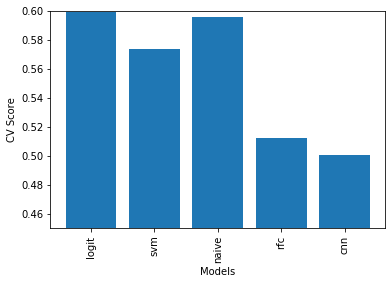

In [346]:
plt.bar(x = nc, height = hv)
plt.ylabel('CV Score')
plt.ylim((0.45, 0.6))
plt.xlabel('Models')
plt.xticks(rotation='vertical')
plt.savefig('hist.png')
plt.savefig('hist.pdf')